Compare visium and wta cell2location models

Load libraries and data:

In [1]:
import sys,os
path = '/nfs/team283/aa16/KR_NAS/'
os.chdir(path)
sys.path.append(path)

In [2]:
import pickle
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
import isctools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


In [3]:
adata_wta = pickle.load(open("/nfs/team283/aa16/InSituCellTools/data/nanostringWTA_fetailBrain_AnnData.p", "rb" ))

In [4]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

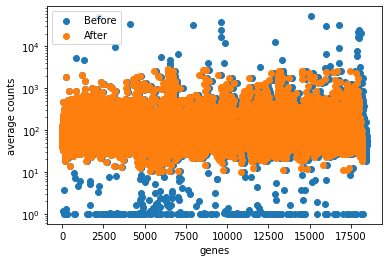

In [5]:
plt.scatter(range(np.shape(adata_wta.X)[1]), np.mean(adata_wta.X, axis = 0), label = 'Before')
plt.yscale('log')
plt.xlabel('genes')
plt.ylabel('average counts')

adata_wta = adata_wta[:, np.mean(adata_wta.X, axis = 0) < 3000]
adata_wta = adata_wta[:, np.mean(adata_wta.X, axis = 0) > 10]

plt.scatter(range(np.shape(adata_wta.X)[1]), np.mean(adata_wta.X, axis = 0), label = 'After')
plt.yscale('log')
plt.xlabel('genes')
plt.ylabel('average counts')
plt.legend()

In [6]:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

Make sure we have the same genes in reference and spatial data:

In [7]:
wta_genes = np.asarray(adata_wta.var_names)
common_genes = [wta_genes[i] for i in range(len(wta_genes)) if wta_genes[i] in meanExpression_sc.index] 
adata_wta = adata_wta[:,[adata_wta.var_names[i] in common_genes + ['NegProbe-WTX'] for i in range(len(adata_wta.var_names))]]
meanExpression_sc = meanExpression_sc.reindex(index = common_genes)

Fit each slide seperately:

In [8]:
slide = '00MU'
adata_slide = adata_wta[[adata_wta.obs['slide'][i] == slide for i in range(len(adata_wta.obs['slide']))]]
print(np.shape(adata_slide))

(74, 15077)


In [9]:
counts_geneProbes = np.asarray(adata_slide[:,np.array(adata_slide.var != 'NegProbe-WTX').squeeze()].X)
counts_negativeProbes = np.asarray(adata_slide[:,np.array(adata_slide.var =='NegProbe-WTX').squeeze()].X)
counts_nuclei = np.array(adata_slide.obs['nuclei']).reshape(len(adata_slide.obs['nuclei']),1)
celltypes = meanExpression_sc.keys()
meanExpression_sc = np.asarray(meanExpression_sc)

In [10]:
celltypes

Index(['End', 'ExDp1', 'ExDp2', 'ExM', 'ExM-U', 'ExN', 'InCGE', 'InMGE', 'IP',
       'Mic', 'OPC', 'oRG', 'Per', 'PgG2M', 'PgS', 'vRG'],
      dtype='object')

In [11]:
models = list()

models.append(isctools.ProbeCounts_CoLocationModel_NB_V1(
        cell_state_mat = meanExpression_sc,
        X_data = counts_geneProbes,
        Y_data = counts_negativeProbes,
        data_type='float32',
        n_iter=20000,
        learning_rate=0.001,
        fact_names=celltypes,
        gene_level_prior={'mean': 1/2, 'sd': 1/8, 'mean_var_ratio': 0.25},
        cell_number_prior={'cells_per_spot': counts_nuclei, 'factors_per_spot': 6, 'combs_per_spot': 5},
        cell_number_var_prior={'cells_mean_var_ratio': 0.1, 'factors_mean_var_ratio': 1, 'combs_mean_var_ratio': 1}))

models.append(isctools.ProbeCounts_CoLocationModel_NB_V2(
        cell_state_mat = meanExpression_sc,
        X_data = counts_geneProbes,
        Y_data = counts_negativeProbes,
        data_type='float32',
        n_iter=20000,
        learning_rate=0.001,
        fact_names=celltypes,
        gene_level_prior={'mean': 1/2, 'sd': 1/8, 'mean_var_ratio': 0.25},
        cell_number_prior={'cells_per_spot': counts_nuclei, 'factors_per_spot': 6, 'combs_per_spot': 5},
        cell_number_var_prior={'cells_mean_var_ratio': 0.1, 'factors_mean_var_ratio': 1, 'combs_mean_var_ratio': 1}))

0


Average Loss = 1.5572e+07: 100%|██████████| 50000/50000 [03:25<00:00, 243.23it/s]
Finished [100%]: Average Loss = 1.5572e+07


1


Average Loss = 4.3802e+06: 100%|██████████| 50000/50000 [03:13<00:00, 258.99it/s]
Finished [100%]: Average Loss = 4.3802e+06


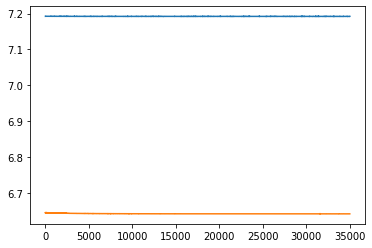

In [12]:
for i in range(2):
    print(i)
    models[i].fit_advi_iterative(n_iter = 50000, learning_rate = 0.001, n=1, method='advi')

Plot history and stability:

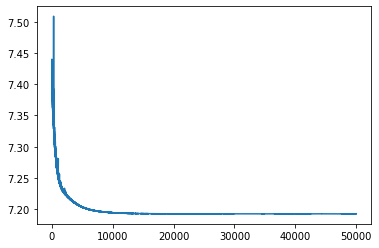

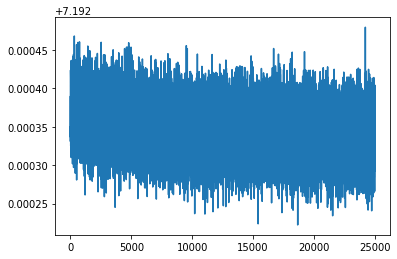

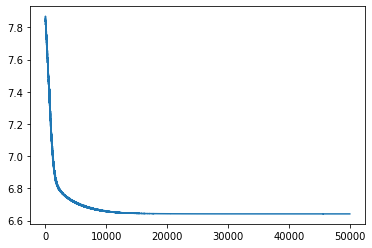

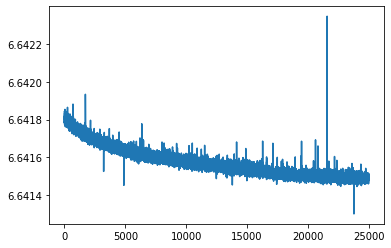

In [13]:
for i in range(2):
    models[i].plot_history()
    plt.show()
    models[i].plot_history(25000)
    plt.show()
    models[i].evaluate_stability()
    plt.show()

Evaluate posterior and plot it vs data:

In [15]:
for i in range(2):
    print(i)
    models[i].sample_posterior(node='all', n_samples=1000, save_samples=False);
    isctools.ProbeCounts_CoLocationModel_Poisson.compute_expected(models[i])
    models[i].plot_posterior_mu_vs_data()
    plt.show()

0
1


ValueError: operands could not be broadcast together with shapes (14940,1) (74,1) 

Calculate the spot factors:

In [16]:
for i in range(2):
    models[i].sample2df(node_name='spot_factors')

Save models just in case:

In [ ]:
pickle.dump(models, file = open( "0_publication_figures_scripts/models_comparison.p", "wb" ))

In [ ]:
#models = pickle.load(open('0_publication_figures_scripts/models.p', 'rb'))

Overview plot of the cell locations in the 19pcw and 14pcw samples:

In [18]:
subset_plot = list()
for i in range(2):
    subset_plot.append([adata_slide.obs['AOI_type'][j] == 'Geometric' and
                        adata_slide.obs['Radial_position'][j] == 2 for j in range(len(adata_slide.obs['AOI_type']))])

We use the colour code that we use for all figures:

In [19]:
colourCode = pickle.load(open('../KR_NAS/0_publication_figures_scripts/celltypesColourCode.p',  "rb"))

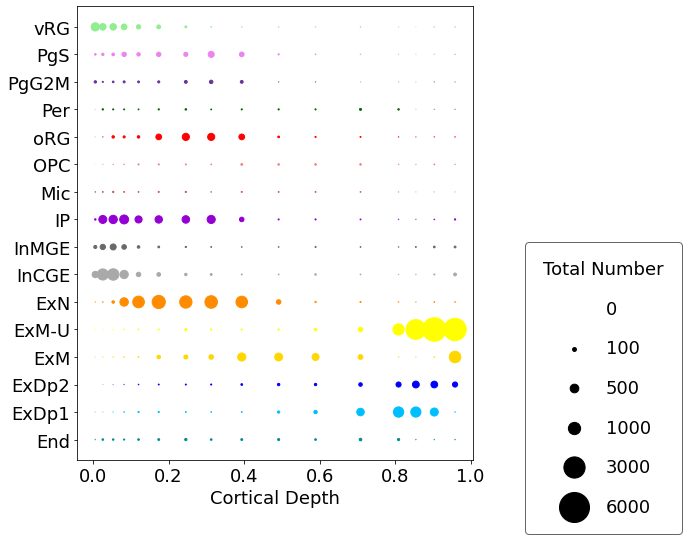

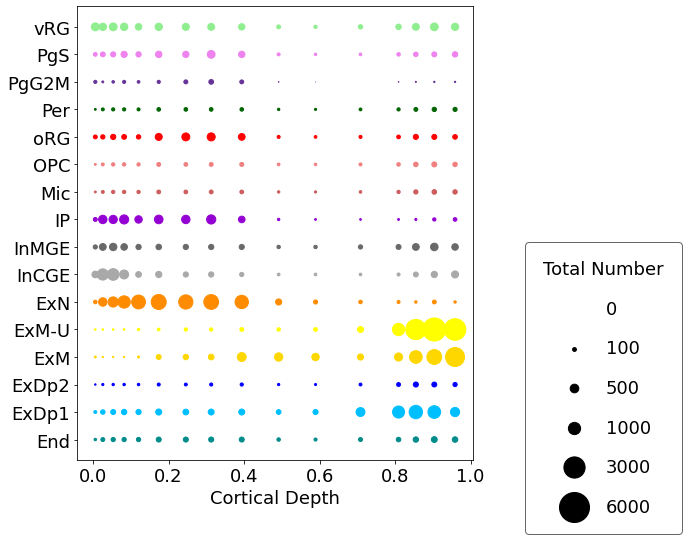

In [21]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 0.15
power = 1

labels = ('19pcw_1', '19pcw_2', '14pcw_1')

for i in range(2):
    
    celltypesForPlot = np.repeat(models[i].fact_names,sum(subset_plot[i]))
    vcForPlot = np.array([adata_slide.obs['VCDepth'].loc[subset_plot[i]] for j in range(len(models[i].fact_names))]).flatten()
    countsForPlot = np.array([models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]] for j in range(len(models[i].fact_names))])
    coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])
    
    cmap = matplotlib.cm.get_cmap('autumn')

    plt.figure(figsize = (12,8))
    plt.scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
                c= coloursForPlot)

    plt.xlabel('Cortical Depth')

    # make a legend:
    pws = [0,0,100,500,1000,3000,6000]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Total Number", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))
    plt.tight_layout()
    plt.savefig('0_publication_figures/Figure3_CelltypeMap_TotalNumber_' + labels[i] + '.pdf')
    

Now make the same plot with density and make a new cellorder:

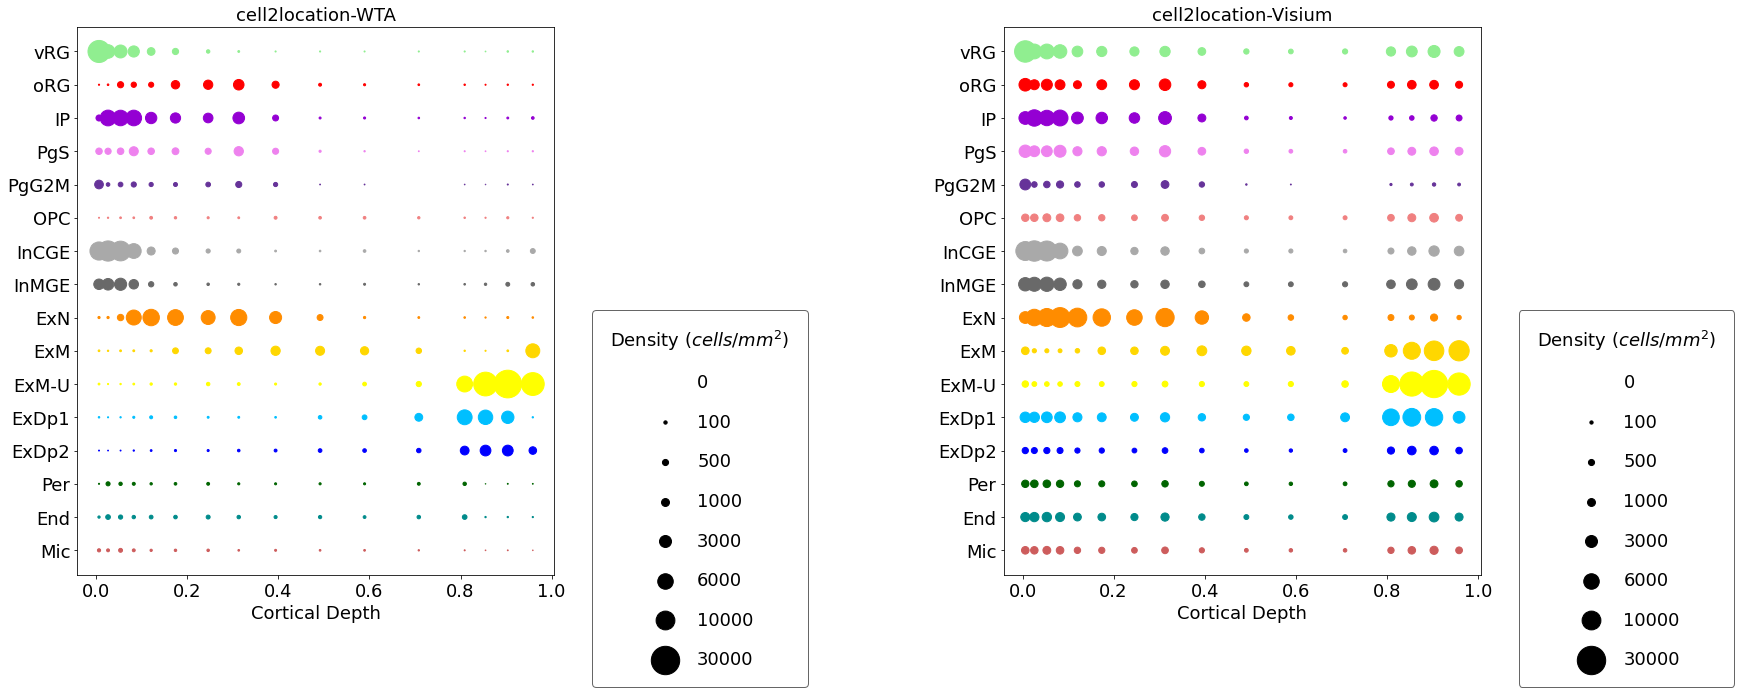

In [31]:
# Reorder cell types:
cellorder = np.array(['vRG','oRG', 'IP', 'PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN','ExM','ExM-U', 'ExDp1', 'ExDp2', 'Per', 'End', 'Mic'])

neworder = np.flipud([np.where(models[i].fact_names == cellorder[j])[0][0] for j in range(len(cellorder))])

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 0.25
power = 0.75

labels = ('19pcw_1', '19pcw_2', '14pcw_1')

fig, ax = plt.subplots(1,2,figsize = (26,10))

for i in range(2):
    
    roi_dimension = np.array(adata_slide.obs['roi_dimension'].iloc[:,0])
    
    celltypesForPlot = np.repeat(models[i].fact_names[neworder],sum(subset_plot[i]))
    vcForPlot = np.array([adata_slide.obs['VCDepth'].loc[subset_plot[i]] for j in range(len(models[i].fact_names))]).flatten()
    countsForPlot = np.array([models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]]/roi_dimension[subset_plot[i]]*10**6
                              for j in neworder])
    coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])
    
    cmap = matplotlib.cm.get_cmap('autumn')

    ax[i].scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
                c= coloursForPlot)

    ax[i].set_xlabel('Cortical Depth')
    ax[i].set_title(('cell2location-WTA', 'cell2location-Visium')[i])

    # make a legend:
    pws = [0,0,100,500,1000,3000,6000,10000, 30000]
    for pw in pws:
        ax[i].scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

    h, l = ax[i].get_legend_handles_labels()
    lgd = ax[i].legend(h[1:], l[1:], labelspacing=1.2, title="Density ($cells/mm^2$)", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))
    plt.tight_layout()
    plt.savefig('0_publication_figures/Figure3_CelltypeMap_Density_ManualOrder' + labels[i] + 'WTA-Visium_ModelComparison.pdf')

Finally make this plot with proportion:

In [ ]:
# Reorder cell types:
cellorder = np.array(['vRG','oRG', 'IP', 'PgS', 'PgG2M', 'OPC', 'InCGE', 'InMGE', 'ExN','ExM','ExM-U', 'ExDp1', 'ExDp2', 'Per', 'End', 'Mic'])

neworder = np.flipud([np.where(models[i].fact_names == cellorder[j])[0][0] for j in range(len(cellorder))])

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 25
power = 2

labels = ('19pcw_1', '19pcw_2', '14pcw_1')

for i in range(2):
    
    roi_dimension = np.array(adata_slide[i].obs['roi_dimension'].iloc[:,0])
    
    celltypesForPlot = np.repeat(models[i].fact_names[neworder],sum(subset_plot[i]))
    vcForPlot = np.array([adata_slide[i].obs['VCDepth'].loc[subset_plot[i]] for j in range(len(models[i].fact_names))]).flatten()
    countsForPlot = np.array([models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]]/roi_dimension[subset_plot[i]]*10**6/
                              sum((models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]]/roi_dimension[subset_plot[i]]*10**6))
                              for j in neworder])
    coloursForPlot = np.array(colourCode.loc[np.array((celltypesForPlot)),'Colour'])
    
    cmap = matplotlib.cm.get_cmap('autumn')

    plt.figure(figsize = (13,10))
    plt.scatter(vcForPlot, celltypesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
                c= coloursForPlot)

    plt.xlabel('Cortical Depth')

    # make a legend:
    pws = [0,0,0.1,0.5,1]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Density/ TotalDensity", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))
    plt.tight_layout()
    plt.savefig('0_publication_figures/Figure3_CelltypeMap_Density_Normalized_ManualOrder' + labels[i] + '.pdf')

Finally, make a line plot only for oRGs:

In [ ]:
# Set figure parameters:

j = np.where(models[i].fact_names == 'oRG')[0][0]

polynomial_order = 6
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(1,1, figsize = (5.5,5))

x = adata_slide[i].obs['VCDepth']
y = models[i].spot_factors_df.iloc[:,j].loc[subset_plot[i]]/roi_dimension[subset_plot[i]]*10**6

ax.plot(np.unique(x[subset_plot[i]]), np.poly1d(np.polyfit(x[subset_plot[i]], y, polynomial_order))(np.unique(x[subset_plot[i]])), c = 'red')
ax.scatter(x[subset_plot[i]], y, c = 'red', s = 100)
ax.set_xlabel('Cortical Depth')
ax.set_ylabel('Density ($cells/ mm^2$)')
ax.set_title('oRG Density')

plt.tight_layout()

plt.savefig('../KR_NAS/0_publication_figures/Figure3A_oRG_Lineplot_Density.pdf')

plt.show()